In [1]:
## First Part: Load the data: 
import pandas as pd 
import numpy as np
import scipy.io

def normalization(x_):
    length = len(x_)
    max_ = np.amax(x_)
    min_ = np.min(x_)
    x_ = 2*(x_ - min_)/(max_ - min_)
    return x_




In [2]:
# # x_train,y_train,x_test,y_test,x_vali,y_vali = ReadData_fer()

# # # Normalization
# # #x_train = normalization(x_train)
# # #x_test = normalization(x_test)
# # #x_vali = normalization(x_vali)

# # x_train = x_train.reshape((len(x_train), 48, 48, 1))
# # x_test = x_test.reshape((len(x_test), 48, 48, 1))
# # x_vali = x_vali.reshape((len(x_vali),48,48,1))
# from keras.utils import to_categorical

# NB_CLASS = 7
# x_train = scipy.io.loadmat('/train/execute/fer2013/x_train.mat')['x_train']
# x_test = scipy.io.loadmat('/train/execute/fer2013/x_test.mat')['x_test']
# x_vali = scipy.io.loadmat('/train/execute/fer2013/x_vali.mat')['x_vali']
# y_train = np.loadtxt('/train/execute/fer2013/y_train.txt')
# y_test = np.loadtxt('/train/execute/fer2013/y_test.txt')
# y_vali = np.loadtxt('/train/execute/fer2013/y_vali.txt')

# # Normalization
# x_train = normalization(x_train)
# x_test = normalization(x_test)
# x_vali = normalization(x_vali)

# x_train = x_train.reshape((len(x_train), 48, 48, 1))
# x_test = x_test.reshape((len(x_test), 48, 48, 1))
# x_vali = x_vali.reshape((len(x_vali),48,48,1))

# y_train = to_categorical(y_train, NB_CLASS)
# y_test = to_categorical(y_test, NB_CLASS)
# y_vali = to_categorical(y_vali, NB_CLASS)

In [3]:
## Train and Vali Split 

In [4]:
def normalization(x_):
    length = len(x_)
    max_ = np.amax(x_)
    min_ = np.min(x_)
    x_ = 2*(x_ - min_)/(max_ - min_)
    return x_


In [5]:
# coding=utf-8, keras model implementation 
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, concatenate, \
    Activation, ZeroPadding2D
from keras.layers import add, Flatten
from keras.utils import plot_model
from keras.metrics import top_k_categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.utils import to_categorical
from keras.regularizers import l2
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import tensorflow as tf
from PIL import Image
import keras.backend.tensorflow_backend as KTF  
KTF.set_session(tf.Session(config=tf.ConfigProto(device_count={'gpu':0})))  

#THEANO_FLAGS=device=gpu, floatX=32


Using TensorFlow backend.


In [6]:
# Global Constants
NB_CLASS=8
IM_WIDTH=224
IM_HEIGHT=224
CHANNEL = 3
batch_size=16
EPOCH=20


def Conv2d_BN(x, nb_filter, kernel_size, strides=(1, 1), padding='same', name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    #x = Conv2D(nb_filter, kernel_size, padding=padding, strides=strides, activation='relu', name=conv_name)(x)
    x = Conv2D(nb_filter, kernel_size, padding=padding, 
               strides=strides,
               kernel_initializer="he_normal",
               kernel_regularizer=l2(1e-5),
               name=conv_name)(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=3, name=bn_name)(x)
    return x


def identity_Block(inpt, nb_filter, kernel_size, strides=(1, 1), with_conv_shortcut=False):
    x = Conv2d_BN(inpt, nb_filter=nb_filter, kernel_size=kernel_size, strides=strides, padding='same')
    x = Conv2d_BN(x, nb_filter=nb_filter, kernel_size=kernel_size, padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inpt, nb_filter=nb_filter, strides=strides, kernel_size=kernel_size)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x

def bottleneck_Block(inpt,nb_filters,strides=(1,1),with_conv_shortcut=False):
    k1,k2,k3=nb_filters
    x = Conv2d_BN(inpt, nb_filter=k1, kernel_size=1, strides=strides, padding='same')
    x = Conv2d_BN(x, nb_filter=k2, kernel_size=3, padding='same')
    x = Conv2d_BN(x, nb_filter=k3, kernel_size=1, padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inpt, nb_filter=k3, strides=strides, kernel_size=1)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x

def resnet_34(width,height,channel,classes):
    inpt = Input(shape=(width, height, channel))
    x = ZeroPadding2D((3, 3))(inpt)
    
    ## channel 全部砍一半
    #conv1
    x = Conv2d_BN(x, nb_filter=64, kernel_size=(7, 7), strides=(2, 2), padding='valid')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    #conv2_x
    x = identity_Block(x, nb_filter=64, kernel_size=(3, 3))
    x = identity_Block(x, nb_filter=64, kernel_size=(3, 3))
    x = identity_Block(x, nb_filter=64, kernel_size=(3, 3))
    #x = Dropout(0.1)(x)

    #conv3_x
    x = identity_Block(x, nb_filter=128, kernel_size=(3, 3), strides=(2, 2), with_conv_shortcut=True)
    x = identity_Block(x, nb_filter=128, kernel_size=(3, 3))
    x = identity_Block(x, nb_filter=128, kernel_size=(3, 3))
    x = identity_Block(x, nb_filter=128, kernel_size=(3, 3))
    #x = Dropout(0.1)(x)

    #conv4_x
    x = identity_Block(x, nb_filter=256, kernel_size=(3, 3), strides=(2, 2), with_conv_shortcut=True)
    x = identity_Block(x, nb_filter=256, kernel_size=(3, 3))
    x = identity_Block(x, nb_filter=256, kernel_size=(3, 3))
    x = identity_Block(x, nb_filter=256, kernel_size=(3, 3))
    x = identity_Block(x, nb_filter=256, kernel_size=(3, 3))
    #x = identity_Block(x, nb_filter=256, kernel_size=(3, 3))
    #x = Dropout(0.1)(x)

    #conv5_x
    x = identity_Block(x, nb_filter=512, kernel_size=(3, 3), strides=(2, 2), with_conv_shortcut=True)
    x = identity_Block(x, nb_filter=512, kernel_size=(3, 3))
    x = identity_Block(x, nb_filter=512, kernel_size=(3, 3))
    #x = AveragePooling2D(pool_size=(7, 7))(x)
    x = AveragePooling2D(pool_size=(2,2))(x)
    #x = AveragePooling2D(pool_size=(4,4))(x)
    #print(x.shape)
    x = Flatten()(x)
    #print("After Flatten",x.shape)
    x = Dense(classes, activation='softmax',
                       kernel_initializer="he_normal",
                       kernel_regularizer = l2(1e-5))(x)
    #x = Dropout(0.5)(x)
    #print("Outputs shape",x)
    #print("Input shape", inpt)
    model = Model(inputs=inpt, outputs=x)
    return model

def acc_top2(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=7)


def check_print():
    # Create a Keras Model
    model = resnet_34(IM_WIDTH,IM_HEIGHT,CHANNEL,NB_CLASS)
    #model.summary()
    # Save a PNG of the Model Build
    #plot_model(model, to_file='resnet.png')
    opt = keras.optimizers.SGD(lr=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc',top_k_categorical_accuracy])
    print('Model Compiled')
    return model



In [7]:
def LoadMapping():
    import numpy as np
    import json

    def LoadJson(path):
        with open(path) as fp:
            result = json.load(fp)    

        return result
    
    mapping_dir = '/train/execute/AffectNet/mapping'
    y_train_path = mapping_dir + '/y_train.txt'
    y_test_path = mapping_dir + '/y_test.txt'
    y_vali_path = mapping_dir + '/y_vali.txt'
    y_train = np.loadtxt(y_train_path)
    y_test = np.loadtxt(y_test_path)
    y_vali = np.loadtxt(y_vali_path)
    x_train = LoadJson(mapping_dir + '/x_train.json')
    x_test = LoadJson(mapping_dir + '/x_test.json')
    x_vali = LoadJson(mapping_dir + '/x_vali.json')
    
    return x_train,y_train,x_test,y_test,x_vali,y_vali

import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, name,batch_size=16, dim=(224,224), n_channels=3,
                 n_classes=8, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.name = name
        #self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.aug_gen = ImageDataGenerator(
                      rotation_range=5,
                      width_shift_range=0.2,
                      height_shift_range=0.2,
                      horizontal_flip=True)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y
    
    def __aug_(self,X,y):
        
        self.aug_gen.fit(X)

        # fits the model on batches with real-time data augmentation:
        return self.aug_gen.flow(X, y, batch_size=self.batch_size).next()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        x_train_map,y_train_map,x_test_map,y_test_map,x_vali_map,y_vali_map = LoadMapping()
        
        #print(len(list_IDs_temp))
        path = '/train/execute/AffectNet/Data/aligned/'
        
        for i in range(len(list_IDs_temp)):
            index = list_IDs_temp[i]
            key = x_train_map[index]#.encode('ascii')
            X[i] = ReadImage(path,key)
            y[i] = y_train_map[index] 

#         if self.name == 'train':
#             for i in range(len(list_IDs_temp)):
#                 index = list_IDs_temp[i]
#                 key = x_train_map[index]#.encode('ascii')
#                 X[i] = ReadImage(path,key)
#                 y[i] = y_train_map[index] 
#         else:
#             for i in range(len(list_IDs_temp)):
#                 index = list_IDs_temp[i]
#                 key = x_vali_map[index]#.encode('ascii')
#                 X[i] = ReadImage(path,key)
#                 y[i] = y_vali_map[index]


        return self.__aug_(X,keras.utils.to_categorical(y, num_classes=self.n_classes))

def ReadImage(path,key):
    
    file_path = path + key
    im_ = Image.open(file_path)
        ### Center Crop
    x = 113 - 14
    y = 130 - 30
    length = 240
    area = (x, y, x+length, y+length)
    im_ = im_.crop(area)
    im_ = (np.array(im_))
    im_ = im_ * (1. / 255) - 0.5
    im_ = RandomCrop(im_,224)
    return im_

def ReadImage_2(path,key):
    
    file_path = path + key
    im_ = Image.open(file_path)
    ### Center Crop
    x = 113 - 14
    y = 130 - 30
    length = 224
    area = (x, y, x+length, y+length)
    im_ = im_.crop(area)
    im_ = (np.array(im_)) 
    im_ = im_ * (1. / 255) - 0.5

    return im_

def RandomCrop(img,random_crop_size):
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy = random_crop_size
    dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def generateListID(length):
    
    result = []
    for i in range(length):
        result.append(i)
    return np.array(result)

In [8]:
#### Read Test Data:
import numpy as np
def ReadTest():
    mapping_dir = '/train/execute/AffectNet/mapping'
    path = '/train/execute/AffectNet/Data/aligned/'
    
    y_test = np.loadtxt(mapping_dir + '/y_test.txt')
    y_test = to_categorical(y_test, num_classes = NB_CLASS)
    with open(mapping_dir + '/x_test.json','r') as fp:
        x_test_mapping = json.load(fp)
        
    X = np.empty((len(y_test),224,224,3))
    
    for i in range(len(y_test)):
        key = x_test_mapping[i] 
        X[i] = ReadImage_2(path,key)
        
    return X, y_test

def ReadVali():
    mapping_dir = '/train/execute/AffectNet/mapping'
    path = '/train/execute/AffectNet/Data/aligned/'
    
    y_ = np.loadtxt(mapping_dir + '/y_vali.txt')
    y_ = to_categorical(y_, num_classes = NB_CLASS)
    with open(mapping_dir + '/x_vali.json','r') as fp:
        x_vali_mapping = json.load(fp)
        
    X = np.empty((len(y_),224,224,3))
    
    for i in range(len(y_)):
        key = x_vali_mapping[i] 
        X[i] = ReadImage_2(path,key)
        
    return X, y_


# x_test,y_test = ReadTest()
# print(x_test.shape)

In [9]:
def Plot(result):
    plt.style.use('ggplot')
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax1.set_title('Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epochs')
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax2.set_title('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epochs')
    #ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
    #ax3.set_title('Time')
    #ax3.set_ylabel('Seconds')
    
    for result in results:
        ax1.plot(result[0].epoch, result[0].history['val_acc'], label='Vali')
        ax1.plot(result[0].epoch, result[0].history['acc'], label='Train')
        ax2.plot(result[0].epoch, result[0].history['val_loss'], label='Vali')
        ax2.plot(result[0].epoch, result[0].history['loss'], label='Train')

    ax1.legend()
    ax2.legend()
    #ax3.bar(np.arange(len(results)), [x[1] for x in results],
    #        align='center')
    plt.tight_layout()
    plt.show()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18101929879177685057
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 182452224
locality {
  bus_id: 1
}
incarnation: 3249332971059886526
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
('Vali Shape', (2871, 224, 224, 3))
(2900, 224, 224, 3)
Model Compiled
Testset Before Training 
2900/2900 [==============================] - 13s    
('Loss :', 7.6549933637421708)
('Accuracy :', 0.37206896559945468)
Epoch 1/20
17759/17759 [==============================] - 3040s - loss: 1.3612 - acc: 0.6084 - top_k_categorical_accuracy: 0.9513 - val_loss: 1.0449 - val_acc: 0.6890 - val_top_k_categorical_accuracy: 0.9763
Epoch 2/20
17759/17759 [==============================] - 3068s - loss: 1.0486 - acc: 0.6841 - top_k_categorical_accuracy: 0.9762 - val_loss: 0.9857 - val_acc: 0.7203 - val_top_k_categorical_accuracy: 0.9868
Epoch 3/20
17759/17

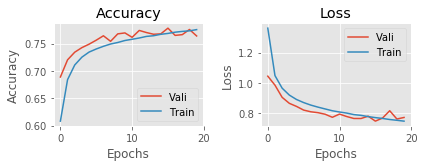

Testset After Training 
2900/2900 [==============================] - 9s     
('Loss :', 0.79777991483951438)
('Accuracy :', 0.75862068973738572)


In [10]:
if __name__ == '__main__':
      
      from tensorflow.python.client import device_lib
      print (device_lib.list_local_devices())

      mapping_dir = '/train/execute/AffectNet/mapping'
      y_train_path = mapping_dir + '/y_train.txt'
      #y_vali_path = mapping_dir + '/y_vali.txt'
      
      y_train = np.loadtxt(y_train_path)
      #y_vali = np.loadtxt(y_vali_path)
      
      x_vali,y_vali = ReadVali()
      print("Vali Shape",x_vali.shape)
      x_test,y_test = ReadTest()
      print(x_test.shape)
      
#       with open(mapping_dir + '/x_vali.json','r') as fp:
#         x_vali_mapping = json.load(fp)
        
#       for i in range(len(x_vali)):
#           print(x_vali_mapping[i])
#           print("i: ",i,x_vali[i])
      ## 
      listID_train = generateListID(len(y_train))
      #listID_vali = generateListID(len(y_vali))
   
      
      params = {'dim': (224,224),
          'batch_size': batch_size,
          'n_classes': NB_CLASS,
          'n_channels': CHANNEL,
          'shuffle': True}
        
      name_1 = 'train'
      #name_2 = 'vali'
      training_generator = DataGenerator(listID_train, name_1 , **params)
      #validation_generator = DataGenerator(listID_vali, name_2, **params)
      
      spe = int(np.floor(len(listID_train) / batch_size))
        
      #print('Steps per epoch: ',spe)
      #vs = int(np.floor(len(listID_vali) / batch_size))
      #print("Validation Steps: ",vs)
    
      model = check_print()
      #model.summary()
      
      print("Testset Before Training ")
      score = model.evaluate(x_test,y_test)
        
      print("Loss :",score[0])
      print("Accuracy :",score[1])
        
      results = []
      start_time = time.time()
      
      history = model.fit_generator(generator=training_generator,
                          steps_per_epoch = spe,
                          validation_data=(x_vali,y_vali),
                          use_multiprocessing=True,
                          epochs=EPOCH, 
                          verbose=1,
                          workers = 30,
                          max_queue_size=40)

            
      average_time_per_epoch = (time.time() - start_time) / EPOCH
      results.append((history, average_time_per_epoch))
      Plot(results)
     
      print("Testset After Training ")
      score = model.evaluate(x_test,y_test)
      print("Loss :",score[0])
      print("Accuracy :",score[1])
      
        
#     from math import ceil
#     path_tfrecords_train = '/train/execute/AffectNet/Data/affectNet.tfrecords'
    
#     model = check_print()
#     model.summary()
#     model.fit_generator(generate_batch_data_random(410176,path_tfrecords_train),epochs=EPOCH,validation_data=(x_vali, y_vali),steps_per_epoch = 25636)  
    
    
#     #model_keras.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',top_k_categorical_accuracy])
#     est_ = tf.keras.estimator.model_to_estimator(keras_model=model_keras)
#     train_spec = tf.estimator.TrainSpec(input_fn=lambda: imgs_input_fn(path_tfrecords_train,perform_shuffle=True,repeat_count=5,batch_size=32), max_steps=500)
#     eval_spec = tf.estimator.EvalSpec(input_fn=lambda: imgs_input_fn(path_tfrecords_vali, perform_shuffle=False, batch_size=1))
#     #est_(input_fn=train_spec, steps=2000)
#     est_.train_and_evaluate(train_spec=train_spec, eval_spec=eval_spec)
    
    
    #train_spec = tf.estimator.TrainSpec(input_fn=lambda: imgs_input_fn(path_tfrecords_train,perform_shuffle=True,repeat_count=5,batch_size=32), max_steps=500)
    #eval_spec = tf.estimator.EvalSpec(input_fn=lambda: imgs_input_fn(path_tfrecords_vali, perform_shuffle=False, batch_size=1))
    #tf.estimator.train_and_evaluate(estimator=est_model, train_spec=train_spec, eval_spec=eval_spec)
    
#     images, labels = imgs_input_fn(path_tfrecords_train)
#     print(type(images))
#     #model_input = keras.Input(tensor=images, shape=(224, 224,3), dtype=tf.uint8, name="input")
#     model_input = Input(shape=(224, 224, 3))
#     model_output = model(tensor = images,shape = model_input)
#     model = keras.models.Model(inputs=model_input, outputs=model_output)
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',top_k_categorical_accuracy],target_tensor = [labels])
#     model.fit(steps_per_epoch=5000, epochs=EPOCH)

#     print(x_train.shape)
#     print(y_train.shape)
#     print(x_test.shape)
#     print(y_test.shape)
#     print(x_vali.shape)
#     print(y_vali.shape)
#     y_train = to_categorical(y_train, NB_CLASS)
#     y_test = to_categorical(y_test, NB_CLASS)
#     y_vali = to_categorical(y_vali, NB_CLASS)

    #print(inpt.shape)

    #if os.path.exists('resnet_34.h5'):
    #    model=load_model('resnet_34.h5')
    #else:
    #model=check_print()

#     results = []
#     start_time = time.time()

#     history = model.fit(x_train, y_train,
#               batch_size = batch_size,
#               epochs= EPOCH,
#               validation_data=(x_vali,y_vali))

#     #scores = model.evaluate(x_test,to_categorical(y_test))
#     #print("Accuracy: ",scores[1])
#     #print("Scores[0] :",scores[0])

#     average_time_per_epoch = (time.time() - start_time) / EPOCH
#     results.append((history, average_time_per_epoch))
#     plt.style.use('ggplot')
#     ax1 = plt.subplot2grid((2, 2), (0, 0))
#     ax1.set_title('Accuracy')
#     ax1.set_ylabel('Accuracy')
#     ax1.set_xlabel('Epochs')
#     ax2 = plt.subplot2grid((2, 2), (0, 1))
#     ax2.set_title('Loss')
#     ax2.set_ylabel('Loss')
#     ax2.set_xlabel('Epochs')
# #     ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
# #     ax3.set_title('Time')
# #     ax3.set_ylabel('Seconds')

#     for result in results:
#         ax1.plot(result[0].epoch, result[0].history['val_acc'], label='Vali')
#         ax1.plot(result[0].epoch, result[0].history['acc'], label='Train')
#         ax2.plot(result[0].epoch, result[0].history['val_loss'], label='Vali')
#         ax2.plot(result[0].epoch, result[0].history['loss'], label='Train')

#     ax1.legend()
#     ax2.legend()
#     #ax3.bar(np.arange(len(results)), [x[1] for x in results],
#     #        align='center')
#     plt.tight_layout()
#     plt.show()

#     score = model.evaluate(x_test, y_test, verbose=0)
#     print('Test loss:', score[0])
#     print('Test accuracy:', score[1])